<a href="https://colab.research.google.com/github/dbtronics/COMP551---Miniproject-3-Classification-of-Image-Data-/blob/main/Group_18_Miniproject_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
import math
import pdb
from tensorflow import keras
import pandas as pd

# Multilayer Perceptron
Multilayer Perceptron Implementation with built-in Gradient Descent optimizer in fit() method

Implemention will take batch or individual sample units. It can be used with SGD or mini-batch SGD or batch GD. This needs to be mentioned in fit() with batch_size parameter.
* If batch_size = N i.e. takes in all samples, then it is Batch Gradient Descent
* If batch_size < N i.e. takes in some samples then it is Mini-Batch Gradient Descent
* If batch_size = 1 i.e. takes in individual samples, then it is Stochastic Gradient Descent

Assumes that all hidden layers have the SAME neurons

In [ ]:
class MLP:
  def __init__ (self, input_neurons, output_neurons, hidden_layer=1, bias=False,
               hidden_neurons=128,learning_rate=5e-3, activation="sigmoid", dropout=False, dropout_percent=0.2):
    # self.epochs = epochs
    self.hidden_layer = hidden_layer
    self.input_neurons = input_neurons
    self.hidden_neurons = hidden_neurons
    self.output_neurons = output_neurons
    # self.batch_size = batch_size # decides on mini/batch stochastic gradiant descent
    self.learning_rate = learning_rate
    # self.epsilon = epsilon
    self.activation = activation # decides on sigmoid, relu, leaky-relu, tanh activation
    # no. of weights dependent on hidden_layers
    self.weights = self.init_weights(self.hidden_layer) 
    # only activated if dropout is True
    self.dropout = dropout
    self.dropout_percent = dropout_percent
    self.dropout_node = self.init_dropout(self.hidden_layer) if self.dropout else None
    self.bias = bias
    self.bh1 = 1 if self.bias else 0 # will only be implemented if user selected bias as True
    self.bh2 = 1 if self.bias else 0 # will only be implemented if user selected bias as True
    self.bout = 1 if self.bias else 0 # will only be implemented if user selected bias as True

  def init_weights(self, hidden_layer):
    if(hidden_layer==0):
      w = np.random.randn(self.input_neurons, self.output_neurons) * np.sqrt(1./self.output_neurons)
      return np.asarray([w])
    elif (hidden_layer==1):
      v = np.random.randn(self.input_neurons, self.hidden_neurons) * np.sqrt(1./self.hidden_neurons)
      w = np.random.randn(self.hidden_neurons, self.output_neurons) * np.sqrt(1./self.output_neurons)
      return np.asarray([v,w])
    elif (hidden_layer==2):
      v = np.random.randn(self.input_neurons, self.hidden_neurons) * np.sqrt(1./self.hidden_neurons)
      r = np.random.randn(self.hidden_neurons, self.hidden_neurons) * np.sqrt(1./self.hidden_neurons)
      w = np.random.randn(self.hidden_neurons, self.output_neurons) * np.sqrt(1./self.output_neurons)
      return np.asarray([v,r,w])
    else:
      print("# of hidden layer should be <= 2")
      return None

  def init_dropout(self, hidden_layer):
    if(hidden_layer>0):
      # d = np.random.rand(self.hidden_neurons)
      # d = d<0.5 # clamps value to 0 and 1 only
      random_index = np.random.permutation(self.hidden_neurons) # creates random index from 0 to M
      drop = np.ones(self.hidden_neurons) # intialize dropout vector
      drop[random_index[:int(self.hidden_neurons*self.dropout_percent)]] = 0 # dropout nodes on selective index
      return drop
    else: return None

  def fit(self, x_train, y_train, batch_size, epochs=200, epsilon=5e-3,): # add batchsize here rather than in __init__
    y_class = np.zeros((y_train.shape[0], np.max(y_train)+1))
    for i in range(y_train.shape[0]): y_class[i,y_train[i]] = 1

    batch_runs = math.ceil(y_train.shape[0]/batch_size)
    
    norm = np.array([np.inf])
    t=0
    while(np.any(norm>epsilon) and t<epochs):
      # pdb.set_trace()
      for batch_index in range(batch_runs): # batch_runs decides if it is mini-batch, stochastic or batch GD
        start = batch_index*batch_size
        end = (batch_index+1)*batch_size
        x_train_batch = x_train[start:end] if end<=y_train.shape[0] else x_train[start:]
        y_train_batch = y_class[start:end] if end<=y_train.shape[0] else y_class[start:] # N x C
        y_train_label_batch = y_train[start:end] if end<=y_train.shape[0] else y_train[start:] # N
        yh = self.forward_pass(x_train_batch)
        dweights = self.back_prop(yh, y_train_batch)
        self.update_weights(np.asarray(dweights))

      # takes into account of 0 layer
      norm = [np.linalg.norm(dweights)] if len(dweights)==1 else [np.linalg.norm(g) for g in dweights]
      norm = np.array(norm)
      # norm = [np.linalg.norm(g) for g in dweights]
      # debug
      # yh = self.forward_pass(x_train)
      # print("Epoch: ", t, " with accuracy of: ", self.eval_acc(np.argmax(yh, axis=-1), y_train))
      # print("Epoch: ", t)
      # print("Norm: ", norm)
      t+=1

  def activation_function(self, z, derivative=False):
    if(self.activation=="sigmoid"):
      return sigmoid(z)*(1-sigmoid(z)) if derivative else sigmoid(z)
    elif(self.activation=="tanh"):
      return 1-np.square(tanh(z)) if derivative else tanh(z)
    elif(self.activation=="relu"):
      return 1*(z>0) if derivative else relu(z)
    elif(self.activation=="leaky-relu"):
      temp = 1*(z>0)
      return (np.array(temp==0, dtype=float)*0.1+temp) if derivative else leaky_relu(z)
    else:
      print("invalid activation function")
      return None
      
  def forward_pass(self, x_train):
    f1 = x_train # N x D
    self.f_params = []
    if(self.hidden_layer==0): # no dropout here since it doesn't have hidden layer
      # input --> output
      f2 = np.dot(f1, self.weights[0]) + np.outer(self.bout*np.ones(x_train.shape[0]), np.ones(self.output_neurons)) # N x C
      f3 = softmax(f2) # N x C
      self.f_params = [f1, f2, f3]
      return f3

    elif (self.hidden_layer==1):
      # input --> first layer
      f2 = np.dot(f1, self.weights[0]) + np.outer(self.bh1*np.ones(x_train.shape[0]), np.ones(self.hidden_neurons)) # N x M
      f3 = self.activation_function(f2) # N x M
      #DROPOUT REGULARIZATION
      f3 = f3*self.dropout_node if (self.dropout) else f3

      # first layer --> output
      f4 = np.dot(f3, self.weights[1]) + np.outer(self.bout*np.ones(x_train.shape[0]), np.ones(self.output_neurons)) # N x C
      f5 = softmax(f4) # N x C
      
      self.f_params = [f1, f2, f3, f4, f5]
      return f5

    elif (self.hidden_layer==2):
      # input --> first layer
      f2 = np.dot(f1, self.weights[0]) + np.outer(self.bh1*np.ones(x_train.shape[0]), np.ones(self.hidden_neurons)) # N x M
      f3 = self.activation_function(f2) # N x M
      #DROPOUT REGULARIZATION
      f3 = f3*self.dropout_node if (self.dropout) else f3

      # first layer --> second layer
      f4 = np.dot(f3, self.weights[1]) + np.outer(self.bh2*np.ones(x_train.shape[0]), np.ones(self.hidden_neurons)) # N x M
      f5 = self.activation_function(f4) # N x M
      #DROPOUT REGULARIZATION
      f5 = f5*self.dropout_node if (self.dropout) else f5

      # second layer --> output
      f6 = np.dot(f5, self.weights[2]) + np.outer(self.bout*np.ones(x_train.shape[0]), np.ones(self.output_neurons)) # N x C
      f7 = softmax(f6) # N x C
      self.f_params = [f1, f2, f3, f4, f5, f6, f7]
      return f7
    
    else:
      print("No forward pass")
      return None

  
  def back_prop(self, y_pred, y_train):
    N = y_pred.shape[0]
    b1 = y_pred-y_train # N x C
    b1 /= np.max(y_train)+1 # average out derivative of cost function
    
    if(self.hidden_layer==0): # No dropout here since it doesn't have a hidden layer
      f1, f2, f3 = self.f_params

      e1 = b1 * softmax_diff(f2) # N x C
      b2 = np.dot(f1.T, e1)/N # D x C

      if self.bias: self.bout -= self.learning_rate*np.mean(np.sum(e1, axis=-1)) # will only update if bias is set to True

      return [b2]

    elif (self.hidden_layer==1):
      f1, f2, f3, f4, f5 = self.f_params
      
      e1 = b1 * softmax_diff(f4) # N x C
      b2 = np.dot(f3.T, e1)/N # M x C
      
      b3 = np.dot(e1, self.weights[1].T) # N x M
      # DROPOUT REGULARIZATION
      b3 = b3*self.dropout_node if self.dropout else b3

      e2 = self.activation_function(f2, derivative=True)
      b4 = np.dot(f1.T, b3*e2)/N # D x M
      
      if self.bias: # will only update if bias is set to True
        self.bout -= self.learning_rate*np.mean(np.sum(e1, axis=-1))
        self.bh1 -= self.learning_rate*np.mean(np.sum(b3*e2, axis=-1))
      return [b4, b2]

    elif (self.hidden_layer==2):
      f1, f2, f3, f4, f5, f6, f7 = self.f_params

      e1 = b1 * softmax_diff(f6) # N x C
      b2 = np.dot(f5.T, e1)/N # M x C

      b3 = np.dot(e1, self.weights[2].T) # N x M
      # DROPOUT REGULARIZATION
      b3 = b3*self.dropout_node if self.dropout else b3

      e2 = self.activation_function(f4, derivative=True) # N x M
      b4 = np.dot((b3*e2).T, f3)/N # M x M

      b5 = np.dot(b3*e2, self.weights[1].T) # N x M
      # DROPOUT REGULARIZATION
      b5 = b5*self.dropout_node if self.dropout else b5

      e3 = self.activation_function(f2, derivative=True) # N x M
      b6 = np.dot(f1.T, (b5*e3))/N # D x M

      if self.bias: # will only update if bias is set to True
        self.bout -= self.learning_rate*np.mean(np.sum(e1, axis=-1))
        self.bh2 -= self.learning_rate*np.mean(np.sum(b3*e2, axis=-1))
        self.bh1 -= self.learning_rate*np.mean(np.sum(b5*e3, axis=-1))
      return [b6, b4, b2]
    
    else:
      print("No backpropagation")
      return None
  
  def update_weights(self, dweights):
    self.weights -= self.learning_rate * dweights

  def predict(self, x_test):
    yh = self.forward_pass(x_test)
    return np.argmax(yh, axis=-1)

  def eval_acc(self, y_pred, y_test):
    acc = y_pred==y_test
    return np.sum(acc)/len(y_test)



## Activation Function
Sigmoid, ReLu, Leaky ReLu, tanh for intermediate layer 

Softmax and derivative for classification and gradient update

In [ ]:
sigmoid = lambda z: 1./ (1 + np.exp(-z))

relu = lambda z: np.maximum(0, z)

tanh = lambda z: np.tanh(z)

leaky_relu = lambda z: np.maximum(0.1*z, z)

# prevent overflow in exponential using z.max()
softmax = lambda z: np.exp(z-z.max()) / np.sum(np.exp(z-z.max()), axis = -1)[:, None] 
softmax_diff = lambda z: softmax(z)*(1-softmax(z))


# Cross-Validation and kFold Validation Testing

In [ ]:
def cross_validation(x_train, y_train, L, i):
  block = int(1/L * x_train.shape[0])
  val_mask = np.zeros(x_train.shape[0], dtype=bool)
  start = block*i
  end = block*(i+1)
  val_mask[start:end] = True # select validation set only
  x_tr = x_train[val_mask]
  y_tr = y_train[val_mask]
  x_val = x_train[val_mask==False] # invert indices boolean to get train set
  y_val = y_train[val_mask==False] # invert indices boolean to get train set
  return x_tr, y_tr, x_val, y_val

In [ ]:
def kFoldCV(model, x, y, L, batch_size):
  train_acc, val_acc = [], []
  for k in range(L):
    x_train, y_train, x_val, y_val = cross_validation(x, y, L, k)
    model.fit(x_train, y_train, batch_size)
    y_val_pred = model.predict(x_val)
    y_train_pred = model.predict(x_train)
    train_acc.append(model.eval_acc(y_train_pred, y_train))
    val_acc.append(model.eval_acc(y_val_pred, y_val))
    print("%d/%d fold completed" %(k+1,L))
  print("Mean [training, validation] accuracy of [%.3f, %.3f]" % 
        (np.mean(train_acc), np.mean(val_acc)))
  return train_acc, val_acc


# Main Body of Code
## Importing Data and normalization
* Normalization from [0, 255] --> [0, 1]
* Important to reduce overflow in exponent operation

In [ ]:
mnist_dataset = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

print("Train image shape: ", train_images.shape)
print("Train label shape: ", train_labels.shape)
print("\nTest image shape: ", test_images.shape)
print("Test label shape: ", test_labels.shape)

# normalize pixel values to domain of 0 and 1
x_train = train_images/255.0
y_train = train_labels

x_test = test_images/255.0
y_test = test_labels

#vectorize the images
x_train = x_train.reshape(x_train.shape[0], -1)
x_test = x_test.reshape(x_test.shape[0], -1)

fraction = 1.0

x_train = x_train[:int(x_train.shape[0]*fraction)]
y_train = y_train[:int(y_train.shape[0]*fraction)]

x_test = x_test[:int(x_test.shape[0]*fraction)]
y_test = y_test[:int(y_test.shape[0]*fraction)]

Train image shape:  (60000, 28, 28)
Train label shape:  (60000,)

Test image shape:  (10000, 28, 28)
Test label shape:  (10000,)


## Selecting optimal training data for optimal performance on test set

* Performance metric is based on accuracy on validation set
* Using k=3 in KFoldCV for cross-validation testing (constant)
* Using batch_size of 50 for Mini-Batch Gradient Descent (constant)
* Using 1 hidden layer MLP (constant)



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


1/3 fold completed
2/3 fold completed
3/3 fold completed
Mean [training, validation] accuracy of [0.795, 0.758]
5 percent test fraction completed with mean accuracy of 0.758
1/3 fold completed
2/3 fold completed
3/3 fold completed
Mean [training, validation] accuracy of [0.833, 0.803]
10 percent test fraction completed with mean accuracy of 0.803
1/3 fold completed
2/3 fold completed
3/3 fold completed
Mean [training, validation] accuracy of [0.834, 0.805]
15 percent test fraction completed with mean accuracy of 0.805
1/3 fold completed
2/3 fold completed
3/3 fold completed
Mean [training, validation] accuracy of [0.849, 0.822]
20 percent test fraction completed with mean accuracy of 0.822


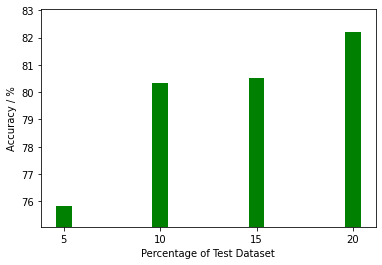


0.20 fraction has the best performance



In [ ]:
training_fraction = [0.05, 0.10, 0.15, 0.20] # looping from 5-20% of training data
training_fraction_test_performance = np.zeros(len(training_fraction))
best_training_fraction = 0

for fr in range(len(training_fraction)):
  x_train_fraction = x_train[:int(x_train.shape[0]*training_fraction[fr])]
  y_train_fraction = y_train[:int(y_train.shape[0]*training_fraction[fr])]
  model_1hl = MLP(x_test.shape[1], np.max(y_test)+1, activation = "relu", hidden_layer=1)
  x_train_acc, x_val_acc = kFoldCV(model_1hl, x_train_fraction, y_train_fraction, 3, 50)
  training_fraction_test_performance[fr] = np.mean(x_val_acc)
  print("%d percent test fraction completed with mean accuracy of %.3f"%
        (int(training_fraction[fr]*100), training_fraction_test_performance[fr]))
plt.bar([fr*100 for fr in training_fraction], [fr*100 for fr in training_fraction_test_performance], color='green')
plt.xlabel("Percentage of Test Dataset")
plt.xticks([fr*100 for fr in training_fraction])
plt.ylabel("Accuracy / %")
bottom = training_fraction_test_performance[np.argmin(training_fraction_test_performance)]*99
top = training_fraction_test_performance[np.argmax(training_fraction_test_performance)]*101
plt.ylim(bottom=bottom)
plt.ylim(top=top)
plt.show()
best_training_fraction = training_fraction[np.argmax(training_fraction_test_performance)] # select best validation acc
print("\n%.2f fraction has the best performance\n" % best_training_fraction)

## Comparing Test Accuracy of 0, 1, and 2 Hidden Layers
* With epsilon of 0.01
* With learning rate of 0.005
* With epoch of 200
* With mini-batch gradient descent of 50
* Activation = ReLU
* Hidden Layer nodes = 128

0 hidden layer completed with accuracy of 0.667


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


1 hidden layer completed with accuracy of 0.816


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


2 hidden layer completed with accuracy of 0.807


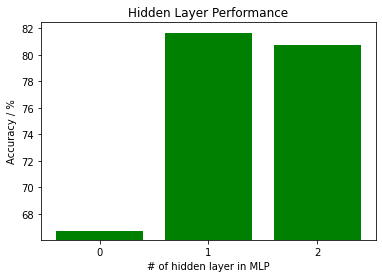


Best hidden layer of MLP is: 1


In [ ]:
hidden_layer = [0, 1, 2]
model_array = []
layer_acc = np.zeros(len(hidden_layer))
best_layer=0 # select the best out of layer_acc array
x_train = x_train[:int(x_train.shape[0]*best_training_fraction)] # values retrieved from before testing
y_train = y_train[:int(y_train.shape[0]*best_training_fraction)] # values retrieved from before testing

for layer_index in range(len(hidden_layer)):
  model = MLP(x_test.shape[1], np.max(y_test)+1, activation = "relu", hidden_layer=hidden_layer[layer_index])
  model.fit(x_train, y_train, 50)
  model_array.append(model)
  yh = model.predict(x_test)
  layer_acc[layer_index] = model.eval_acc(yh, y_test)
  print("%d hidden layer completed with accuracy of %.3f" %(hidden_layer[layer_index], layer_acc[layer_index]))
best_layer = np.argmax(layer_acc)
plt.bar(hidden_layer, [fr*100 for fr in layer_acc], color='green')
plt.xlabel("# of hidden layer in MLP")
plt.xticks(hidden_layer)
plt.ylabel("Accuracy / %")
plt.title("Hidden Layer Performance")
bottom = layer_acc[np.argmin(layer_acc)]*99
top = layer_acc[np.argmax(layer_acc)]*101
plt.ylim(bottom=bottom)
plt.ylim(top=top)
plt.show()
print("\nBest hidden layer of MLP is: %d"%best_layer)

## Bias vs Non-Bias
Using the best MLP hidden layer and training fraction from above

***NOTE: DIFFERENCE BETWEEN BIAS AND NON-BIAS IS EXTREMELY SMALL (0.4%). SOMETIMES ONE IS GREATER THAN THE OTHER.***

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


1/3 fold completed
2/3 fold completed
3/3 fold completed
Mean [training, validation] accuracy of [0.845, 0.818]
Without Bias Completed with accuracy on test dataset: 0.815
1/3 fold completed
2/3 fold completed
3/3 fold completed
Mean [training, validation] accuracy of [0.847, 0.815]
With Bias Completed with accuracy on test dataset: 0.811


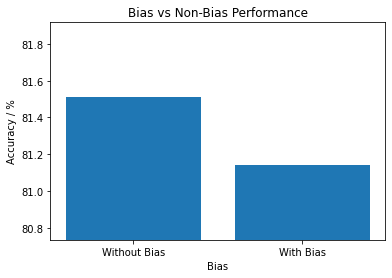


Bias should be selected?  False


In [ ]:
bias_array = [False, True]
bias_string = ["Without Bias", "With Bias"]
bias_performance = np.zeros(len(bias_array))
bias_bool = False # Default

for bias_index in range(len(bias_array)):
  model = MLP(x_test.shape[1], np.max(y_test)+1, activation = "relu", 
              hidden_layer=best_layer, bias=bias_array[bias_index])
  x_train_acc, x_val_acc = kFoldCV(model, x_train_fraction, y_train_fraction, 3, 50)
  # bias_performance[bias_index] = np.mean(x_val_acc)
  yh = model.predict(x_test)
  bias_performance[bias_index] = model.eval_acc(yh, y_test)
  print("%s Completed with accuracy on test dataset: %.3f" % (bias_string[bias_index], bias_performance[bias_index]))
bias_bool = bias_array[np.argmax(bias_performance)]
plt.bar(bias_string, [fr*100 for fr in bias_performance])
plt.title("Bias vs Non-Bias Performance")
plt.xlabel("Bias")
plt.ylabel("Accuracy / %")
bottom = bias_performance[np.argmin(bias_performance)]*99.5
top = bias_performance[np.argmax(bias_performance)]*100.5
plt.ylim(bottom=bottom)
plt.ylim(top=top)
plt.show()
print("\nBias should be selected? ", bias_bool)

## Comparing Test Accuracy with different Activation Function
* Sigmoid
* Relu
* Leaky Relu
* tanh

Keeping the following parameters constant
* Hidden layer neurons = 128 (default)
* Number of hidden layers = 2
* epochs = 200
* epsilon and learning rate = 0.01 and 0.005
* batch size of 50 for mini-batch GD

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


sigmoid activation completed with accuracy of 0.472
relu activation completed with accuracy of 0.811
leaky-relu activation completed with accuracy of 0.813
tanh activation completed with accuracy of 0.818


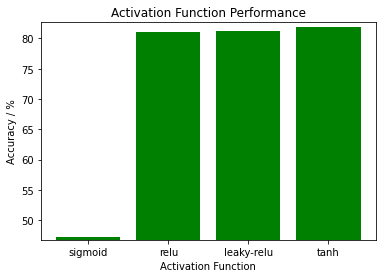


Best activation function is tanh


In [ ]:
activation_array = ["sigmoid", "relu", "leaky-relu", "tanh"]
best_activation=""
act_acc = np.zeros(len(activation_array))
for activation_index in range(len(activation_array)):
  model = MLP(x_test.shape[1], np.max(y_test)+1, activation = activation_array[activation_index], hidden_layer=2, bias=bias_bool)
  model.fit(x_train, y_train, 50)
  yh = model.predict(x_test)
  act_acc[activation_index] = model.eval_acc(yh, y_test)
  print("%s activation completed with accuracy of %.3f" % (activation_array[activation_index], act_acc[activation_index]))
best_activation = activation_array[np.argmax(act_acc)]
plt.bar(activation_array, [fr*100 for fr in act_acc], color="green")
plt.title("Activation Function Performance")
plt.xlabel("Activation Function")
plt.ylabel("Accuracy / %")
bottom = act_acc[np.argmin(act_acc)]*99
top = act_acc[np.argmax(act_acc)]*101
plt.ylim(bottom=bottom)
plt.ylim(top=top)
plt.show()
print("\nBest activation function is %s" % best_activation)

## Dropout Regularization
* Has tunable hyper-perimeter (dropout_percent)
  * Hyper-parameter domain {0.05, 0.1, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50}

Following are parameter configuration:

* Hidden layer neurons = 128 (default)
* Number of hidden layers = 2
* epochs = 200
* epsilon and learning rate = 0.01 and 0.005
* batch size of 50 for mini-batch GD
* ReLU activation

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


5.0 dropout percentage completed with accuracy of 0.808
10.0 dropout percentage completed with accuracy of 0.811
15.0 dropout percentage completed with accuracy of 0.797
20.0 dropout percentage completed with accuracy of 0.807
25.0 dropout percentage completed with accuracy of 0.810
30.0 dropout percentage completed with accuracy of 0.809
35.0 dropout percentage completed with accuracy of 0.794
40.0 dropout percentage completed with accuracy of 0.785
45.0 dropout percentage completed with accuracy of 0.798
50.0 dropout percentage completed with accuracy of 0.787


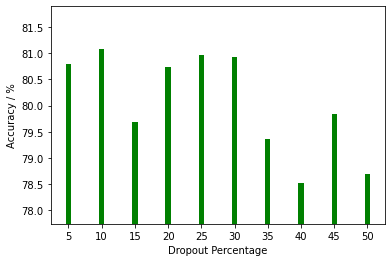


Best dropout percentage is 10


In [ ]:
dropout_percentage = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45, 0.50] # going from 5-50% dropout
# dropout_performance = np.zeros(len(dropout_percentage))
dropout_acc = np.zeros(len(dropout_percentage))
best_dropout_percentage = 0

for dropout_index in range(len(dropout_percentage)):
  model = MLP(x_test.shape[1], np.max(y_test)+1, activation = "relu", hidden_layer=2,
            dropout=True, dropout_percent=dropout_percentage[dropout_index], bias=bias_bool)
  model.fit(x_train, y_train, 50)
  yh = model.predict(x_test)
  dropout_acc[dropout_index] = model.eval_acc(yh, y_test)
  print("%.1f dropout percentage completed with accuracy of %.3f" %
        (int(dropout_percentage[dropout_index]*100), dropout_acc[dropout_index]))
plt.bar([fr*100 for fr in dropout_percentage], [fr*100 for fr in dropout_acc], color="green")
plt.xticks([fr*100 for fr in dropout_percentage])
plt.xlabel("Dropout Percentage")
plt.ylabel("Accuracy / %")
bottom = dropout_acc[np.argmin(dropout_acc)]*99
top = dropout_acc[np.argmax(dropout_acc)]*101
plt.ylim(bottom=bottom)
plt.ylim(top=top)
plt.show()
best_dropout_percentage = dropout_percentage[np.argmax(dropout_acc)]
print("\nBest dropout percentage is %.1d" % int(best_dropout_percentage*100))

## Convolutional Neural Network (CNN)
* Using ***Adams*** optimizer compared to our ***Vanilla*** implementation
* Using epoch of 5
* Mini-Batch SGD with batch_size of 32

In [ ]:
x_train_f = x_train.reshape((-1, 28, 28, 1))
x_test_f = x_test.reshape((-1, 28, 28, 1))

model = tf.keras.Sequential([tf.keras.layers.Conv2D(32, (3,3), padding='same', activation=tf.nn.relu, input_shape=(28, 28, 1)),
                             tf.keras.layers.Conv2D(64, (3,3), padding='same', activation=tf.nn.relu),
                             tf.keras.layers.Flatten(),
                             tf.keras.layers.Dense(128,activation=tf.nn.relu),
                             tf.keras.layers.Dense(128,activation=tf.nn.relu),
                             tf.keras.layers.Dense(10, activation="softmax")
])

model.summary()

print("")

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train_f, y_train, epochs=5)
model.evaluate(x_test_f,  y_test, verbose=2)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 flatten_2 (Flatten)         (None, 50176)             0         
                                                                 
 dense_6 (Dense)             (None, 128)               6422656   
                                                                 
 dense_7 (Dense)             (None, 128)               16512     
                                                                 
 dense_8 (Dense)             (None, 10)                1290      
                                                                 
Total params: 6,459,274
Trainable params: 6,459,274
No

[0.4300035536289215, 0.875]

## Best Network Perimeters
Based on previous results, the optimal perimeters are:
* 15% Training Dataset
* tanh Activation
* Dropout percentage of 20%
* Hidden layer of 1
* Bias included --> evaluated to ***FALSE*** (Based on result)

Keeping following perimeter configuration
* Hidden layer neurons = 128 (default)
* epochs = 200
* epsilon and learning rate = 0.01 and 0.005
* batch size of 50 for mini-batch GD

In [ ]:
optimal_model = MLP(x_train.shape[1], np.max(y_train)+1, activation=best_activation, 
                    dropout=True, dropout_percent=best_dropout_percentage, 
                    hidden_layer=best_layer, bias=bias_bool)
optimal_model.fit(x_train, y_train, 50)
y_train_pred = optimal_model.predict(x_train)
y_test_pred = optimal_model.predict(x_test)
print("Prediction complete and based on the optimal model, following are the accuracies:\n\n")
print("Training Dataset accuracy of %.2f" % optimal_model.eval_acc(y_train_pred, y_train))
print("Unseen Dataset accuracy of %.2f" % optimal_model.eval_acc(y_test_pred, y_test))
print("\nBased on the following best network parameter")
print("# of Hidden Layer: ", best_layer)
print("Activation Function: ", best_activation)
print("Dropout Percentage: ", best_dropout_percentage*100)
print("Bias: ", bias_bool)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


Prediction complete and based on the optimal model, following are the accuracies:


Training Dataset accuracy of 0.85
Unseen Dataset accuracy of 0.82

Based on the following best network parameter
# of Hidden Layer:  1
Activation Function:  tanh
Dropout Percentage:  10.0
Bias:  False


## Training Network with Unnormalized Image
Using different activation function with unnormalized images

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: overflow encountered in exp
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:76: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


sigmoid activation completed with accuracy of 0.666


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


relu activation completed with accuracy of 0.100
leaky-relu activation completed with accuracy of 0.100
tanh activation completed with accuracy of 0.775


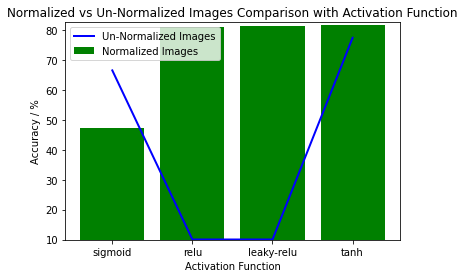

In [ ]:
# converting to unnormalized images by converting [0,1] --> [0,255]
x_train *= 255.0
x_test *= 255.0

act_acc_unnorm = np.zeros(len(activation_array))

# act_acc = np.zeros(len(activation_array))
for activation_index in range(len(activation_array)):
  model = MLP(x_test.shape[1], np.max(y_test)+1, activation = activation_array[activation_index], 
              hidden_layer=2, bias=bias_bool)
  model.fit(x_train, y_train, 50)
  yh = model.predict(x_test)
  act_acc_unnorm[activation_index] = model.eval_acc(yh, y_test)
  print("%s activation completed with accuracy of %.3f" % (activation_array[activation_index], act_acc_unnorm[activation_index]))
# best_activation = activation_array[np.argmax(act_acc)]
plt.plot(activation_array, [fr*100 for fr in act_acc_unnorm], linewidth=2, color="blue", label="Un-Normalized Images")
plt.bar(activation_array, [fr*100 for fr in act_acc], color="Green", label="Normalized Images")
plt.legend(loc="upper left")
plt.title("Normalized vs Un-Normalized Images Comparison with Activation Function")
plt.xlabel("Activation Function")
plt.ylabel("Accuracy / %")
bottom = act_acc_unnorm[np.argmin(act_acc_unnorm)]*99
top = act_acc[np.argmax(act_acc)]*101
plt.ylim(bottom=bottom)
plt.ylim(top=top)
plt.show()

TEST AREA

In [ ]:
# print(x_test[:3, 200:300])

In [ ]:
# fraction = 0.20

# # x_test = x_test[:int(x_test.shape[0]*fraction)]
# # y_test = y_test[:int(y_test.shape[0]*fraction)]

# model = MLP(x_train.shape[1], np.max(y_train)+1, hidden_layer=1, activation="relu", learning_rate=1e-2, bias=True)
# model.fit(x_train, y_train, 50, epochs=20)
# yh = model.predict(x_test)
# print(model.eval_acc(yh, y_test))